# Gameday Model for SPX

In [1]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import yfinance as yf
import json
import requests
from bs4 import BeautifulSoup
from typing import List
import xgboost as xgb
from tqdm import tqdm
from sklearn import linear_model, ensemble

# Helper Functions

In [2]:
def walk_forward_validation(df, target_column, num_training_rows, num_periods):
    
    # Create an XGBRegressor model
    # model = xgb.XGBRegressor(n_estimators=100, objective='reg:squarederror', random_state = 42)
    model = linear_model.LinearRegression()

    overall_results = []
    # Iterate over the rows in the DataFrame, one step at a time
    for i in tqdm(range(num_training_rows, df.shape[0] - num_periods + 1)):
        # Split the data into training and test sets
        X_train = df.drop(target_column, axis=1).iloc[:i]
        y_train = df[target_column].iloc[:i]
        X_test = df.drop(target_column, axis=1).iloc[i:i+num_periods]
        y_test = df[target_column].iloc[i:i+num_periods]
        
        # Fit the model to the training data
        model.fit(X_train, y_train)
        
        # Make a prediction on the test data
        predictions = model.predict(X_test)
        
        # Create a DataFrame to store the true and predicted values
        result_df = pd.DataFrame({'True': y_test, 'Predicted': predictions}, index=y_test.index)
        
        overall_results.append(result_df)

    df_results = pd.concat(overall_results)
    # model.save_model('model_lr.bin')
    # Return the true and predicted values, and fitted model
    return df_results, model

def walk_forward_validation_clf(df, target_column, num_training_rows, num_periods):
    
    # Create an XGBRegressor model
    model = xgb.XGBClassifier(n_estimators=10, random_state = 42)
    # model = linear_model.LogisticRegression(max_iter=2000)
    # model = ensemble.AdaBoostClassifier(n_estimators=10, random_state=42)

    
    overall_results = []
    # Iterate over the rows in the DataFrame, one step at a time
    for i in tqdm(range(num_training_rows, df.shape[0] - num_periods + 1)):
        # Split the data into training and test sets
        X_train = df.drop(target_column, axis=1).iloc[:i]
        y_train = df[target_column].iloc[:i]
        X_test = df.drop(target_column, axis=1).iloc[i:i+num_periods]
        y_test = df[target_column].iloc[i:i+num_periods]
        
        # Fit the model to the training data
        model.fit(X_train, y_train)
        
        # Make a prediction on the test data
        predictions = model.predict_proba(X_test)[:,-1]
        
        # Create a DataFrame to store the true and predicted values
        result_df = pd.DataFrame({'True': y_test, 'Predicted': predictions}, index=y_test.index)
        
        overall_results.append(result_df)

    df_results = pd.concat(overall_results)
    # model.save_model('model_clf_lr.bin')
    # Return the true and predicted values, and fitted model
    return df_results, model

def walk_forward_validation_seq(df, target_column_clf, target_column_regr, num_training_rows, num_periods):

    # Create run the regression model to get its target
    res, _ = walk_forward_validation(df.drop(columns=[target_column_clf]).dropna(), target_column_regr, num_training_rows, num_periods)
    
    # Merge the result df back on the df for feeding into the classifier
    for_merge = res[['Predicted']]
    for_merge.columns = ['RegrModelOut']
    for_merge['RegrModelOut'] = for_merge['RegrModelOut'] > 0
    df = df.merge(for_merge, left_index=True, right_index=True)
    df = df.drop(columns=[target_column_regr])
    df = df[[
        'CurrentGap','RegrModelOut','GapLevel',target_column_clf
        ]]
    
    df[target_column_clf] = df[target_column_clf].astype(bool)
    df['RegrModelOut'] = df['RegrModelOut'].astype(bool)

    # Create an XGBRegressor model
    model = xgb.XGBClassifier(n_estimators=10, random_state = 42)
    # model = linear_model.LogisticRegression(max_iter=1500)

    
    overall_results = []
    # Iterate over the rows in the DataFrame, one step at a time
    for i in tqdm(range(num_training_rows, df.shape[0] - num_periods + 1)):
        # Split the data into training and test sets
        X_train = df.drop(target_column_clf, axis=1).iloc[:i]
        y_train = df[target_column_clf].iloc[:i]
        X_test = df.drop(target_column_clf, axis=1).iloc[i:i+num_periods]
        y_test = df[target_column_clf].iloc[i:i+num_periods]
        
        # Fit the model to the training data
        model.fit(X_train, y_train)
        
        # Make a prediction on the test data
        predictions = model.predict_proba(X_test)[:,-1]
        
        # Create a DataFrame to store the true and predicted values
        result_df = pd.DataFrame({'True': y_test, 'Predicted': predictions}, index=y_test.index)
        
        overall_results.append(result_df)

    df_results = pd.concat(overall_results)
    # model.save_model('model_ensemble.bin')
    # Return the true and predicted values, and fitted model
    return df_results, model

def seq_predict_proba(df, trained_reg_model, trained_clf_model):
    regr_pred = trained_reg_model.predict(df)
    regr_pred = regr_pred > 0
    new_df = df.copy()
    new_df['RegrModelOut'] = regr_pred
    clf_pred_proba = trained_clf_model.predict_proba(new_df[['CurrentGap','RegrModelOut','GapLevel']])[:,-1]
    return clf_pred_proba

In [3]:
f = open('settings.json')
j = json.load(f)

API_KEY_FRED = j['API_KEY_FRED']

def parse_release_dates(release_id: str) -> List[str]:
    release_dates_url = f'https://api.stlouisfed.org/fred/release/dates?release_id={release_id}&realtime_start=2015-01-01&include_release_dates_with_no_data=true&api_key={API_KEY_FRED}'
    r = requests.get(release_dates_url)
    text = r.text
    soup = BeautifulSoup(text, 'xml')
    dates = []
    for release_date_tag in soup.find_all('release_date', {'release_id': release_id}):
        dates.append(release_date_tag.text)
    return dates

def parse_release_dates_obs(series_id: str) -> List[str]:
    obs_url = f'https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&realtime_start=2015-01-01&include_release_dates_with_no_data=true&api_key={API_KEY_FRED}'
    r = requests.get(obs_url)
    text = r.text
    soup = BeautifulSoup(text, 'xml')
    observations  = []
    for observation_tag in soup.find_all('observation'):
        date = observation_tag.get('date')
        value = observation_tag.get('value')
        observations.append((date, value))
    return observations

econ_dfs = {}

econ_tickers = [
    'WALCL',
    'NFCI',
    'WRESBAL'
]

for et in tqdm(econ_tickers, desc='getting econ tickers'):
    # p = parse_release_dates_obs(et)
    # df = pd.DataFrame(columns = ['ds',et], data = p)
    df = pdr.get_data_fred(et)
    df.index = df.index.rename('ds')
    # df.index = pd.to_datetime(df.index.rename('ds')).dt.tz_localize(None)
    # df['ds'] = pd.to_datetime(df['ds']).dt.tz_localize(None)
    econ_dfs[et] = df

# walcl = pd.DataFrame(columns = ['ds','WALCL'], data = p)
# walcl['ds'] = pd.to_datetime(walcl['ds']).dt.tz_localize(None)

# nfci = pd.DataFrame(columns = ['ds','NFCI'], data = p2)
# nfci['ds'] = pd.to_datetime(nfci['ds']).dt.tz_localize(None)

release_ids = [
    "10", # "Consumer Price Index"
    "46", # "Producer Price Index"
    "50", # "Employment Situation"
    "53", # "Gross Domestic Product"
    "103", # "Discount Rate Meeting Minutes"
    "180", # "Unemployment Insurance Weekly Claims Report"
    "194", # "ADP National Employment Report"
    "323" # "Trimmed Mean PCE Inflation Rate"
]

release_names = [
    "CPI",
    "PPI",
    "NFP",
    "GDP",
    "FOMC",
    "UNEMP",
    "ADP",
    "PCE"
]

releases = {}

for rid, n in tqdm(zip(release_ids, release_names), total = len(release_ids), desc='Getting release dates'):
    releases[rid] = {}
    releases[rid]['dates'] = parse_release_dates(rid)
    releases[rid]['name'] = n 

# Create a DF that has all dates with the name of the col as 1
# Once merged on the main dataframe, days with econ events will be 1 or None. Fill NA with 0
# This column serves as the true/false indicator of whether there was economic data released that day.
for rid in tqdm(release_ids, desc='Making indicators'):
    releases[rid]['df'] = pd.DataFrame(
        index=releases[rid]['dates'],
        data={
        releases[rid]['name']: 1
        })
    releases[rid]['df'].index = pd.DatetimeIndex(releases[rid]['df'].index)
    # releases[rid]['df']['ds'] = pd.to_datetime(releases[rid]['df']['ds']).dt.tz_localize(None)
    # releases[rid]['df'] = releases[rid]['df'].set_index('ds')

Making indicators: 100%|██████████| 8/8 [00:00<00:00, 2677.71it/s]


# Data Gathering & Prep

In [4]:
vix = yf.Ticker('^VIX')
spx = yf.Ticker('^GSPC')

prices_vix = vix.history(start='2018-07-01', interval='1d')
prices_spx = spx.history(start='2018-07-01', interval='1d')
# prices_vix = vix.history(start='2020-01-01', interval='1d')
# prices_spx = spx.history(start='2020-01-01', interval='1d')

In [5]:
prices_spx['index'] = [str(x).split()[0] for x in prices_spx.index]
prices_spx['index'] = pd.to_datetime(prices_spx['index']).dt.date
prices_spx.index = prices_spx['index']
prices_spx = prices_spx.drop(columns='index')

prices_vix['index'] = [str(x).split()[0] for x in prices_vix.index]
prices_vix['index'] = pd.to_datetime(prices_vix['index']).dt.date
prices_vix.index = prices_vix['index']
prices_vix = prices_vix.drop(columns='index')

data = prices_spx.merge(prices_vix[['Open','High','Low','Close']], left_index=True, right_index=True, suffixes=['','_VIX'])
data.index = pd.DatetimeIndex(data.index)

## Feature Development

In [6]:
# Features
data['PrevClose'] = data['Close'].shift(1)
data['Perf5Day'] = data['Close'] > data['Close'].shift(5)
data['Perf5Day_n1'] = data['Perf5Day'].shift(1)
data['Perf5Day_n1'] = data['Perf5Day_n1'].astype(bool)
data['GreenDay'] = (data['Close'] > data['PrevClose']) * 1
data['RedDay'] = (data['Close'] <= data['PrevClose']) * 1

data['VIX5Day'] = data['Close_VIX'] > data['Close_VIX'].shift(5)
data['VIX5Day_n1'] = data['VIX5Day'].astype(bool)

data['Range'] = data[['Open','High']].max(axis=1) - data[['Low','Open']].min(axis=1) # Current day range in points
data['RangePct'] = data['Range'] / data['Close']
data['VIXLevel'] = pd.qcut(data['Close_VIX'], 4)
data['OHLC4_VIX'] = data[['Open_VIX','High_VIX','Low_VIX','Close_VIX']].mean(axis=1)
data['OHLC4'] = data[['Open','High','Low','Close']].mean(axis=1)
data['OHLC4_Trend'] = data['OHLC4'] > data['OHLC4'].shift(1)
data['OHLC4_Trend_n1'] = data['OHLC4_Trend'].shift(1)
data['OHLC4_Trend_n1'] = data['OHLC4_Trend_n1'].astype(float)
data['OHLC4_Trend_n2'] = data['OHLC4_Trend'].shift(1)
data['OHLC4_Trend_n2'] = data['OHLC4_Trend_n2'].astype(float)
data['RangePct_n1'] = data['RangePct'].shift(1)
data['RangePct_n2'] = data['RangePct'].shift(2)
data['OHLC4_VIX_n1'] = data['OHLC4_VIX'].shift(1)
data['OHLC4_VIX_n2'] = data['OHLC4_VIX'].shift(2)
data['CurrentGap'] = (data['Open'] - data['PrevClose']) / data['PrevClose']
data['CurrentGap'] = data['CurrentGap'].shift(-1)
data['GapLevel'] = data['CurrentGap'].apply(lambda x: 1 if x < -0.0033 else 2 if x < -0.0015 else 3 if x < 0.0016 else 4)
data['GapLevel'] = data['GapLevel'].astype(int)
data['DayOfWeek'] = pd.to_datetime(data.index)
data['DayOfWeek'] = data['DayOfWeek'].dt.day

# Target -- the next day's low
data['Target'] = (data['OHLC4'] / data['PrevClose']) - 1
data['Target'] = data['Target'].shift(-1)
# data['Target'] = data['RangePct'].shift(-1)

# Target for clf -- whether tomorrow will close above or below today's close
data['Target_clf'] = data['Close'] > data['PrevClose']
data['Target_clf'] = data['Target_clf'].shift(-1)
data['DayOfWeek'] = pd.to_datetime(data.index)
data['Quarter'] = data['DayOfWeek'].dt.quarter
data['DayOfWeek'] = data['DayOfWeek'].dt.weekday

for rid in tqdm(release_ids, desc='Merging econ data'):
    # Get the name of the release
    n = releases[rid]['name']
    # Merge the corresponding DF of the release
    data = data.merge(releases[rid]['df'], how = 'left', left_index=True, right_index=True)
    # Create a column that shifts the value in the merged column up by 1
    data[f'{n}_shift'] = data[n].shift(-1)
    # Fill the rest with zeroes
    data[n] = data[n].fillna(0)
    data[f'{n}_shift'] = data[f'{n}_shift'].fillna(0)
    
data['BigNewsDay'] = data[[x for x in data.columns if '_shift' in x]].max(axis=1)

Merging econ data: 100%|██████████| 8/8 [00:00<00:00, 999.18it/s]


In [7]:
def cumul_sum(col):
    nums = []
    s = 0
    for x in col:
        if x == 1:
            s += 1
        elif x == 0:
            s = 0
        nums.append(s)
    return nums

consec_green = cumul_sum(data['GreenDay'].values)
consec_red = cumul_sum(data['RedDay'].values)

data['DaysGreen'] = consec_green
data['DaysRed'] = consec_red

In [8]:
max(consec_red)

7

In [9]:
data[['GreenDay','DaysGreen']]

,GreenDay,DaysGreen
index,,
2018-07-02,0,0
2018-07-03,0,0
2018-07-05,1,1
2018-07-06,1,2
2018-07-09,1,3
...,...,...
2023-07-10,1,1
2023-07-11,1,2
2023-07-12,1,3


## Model Data

In [10]:
final_row = data.index[-2]

In [11]:
final_row

Timestamp('2023-07-13 00:00:00')

In [12]:
df_final = data.loc[:final_row,
[
    'BigNewsDay',
    'Quarter',
    'Perf5Day',
    'Perf5Day_n1',
    'DaysGreen',
    'DaysRed',
    # 'OHLC4_Trend',
    # 'OHLC4_Trend_n1',
    # 'OHLC4_Trend_n2',
    # 'VIX5Day',
    # 'VIX5Day_n1',
    'CurrentGap',
    'GapLevel',
    'RangePct',
    'RangePct_n1',
    'RangePct_n2',
    'OHLC4_VIX',
    'OHLC4_VIX_n1',
    'OHLC4_VIX_n2',
    'Target',
    'Target_clf'
    ]]
df_final = df_final.dropna(subset=['Target','Target_clf','Perf5Day_n1'])

In [13]:
df_final.drop(columns=['Target_clf']).dtypes

BigNewsDay      float64
Quarter           int64
Perf5Day           bool
Perf5Day_n1        bool
DaysGreen         int64
DaysRed           int64
CurrentGap      float64
GapLevel          int32
RangePct        float64
RangePct_n1     float64
RangePct_n2     float64
OHLC4_VIX       float64
OHLC4_VIX_n1    float64
OHLC4_VIX_n2    float64
Target          float64
dtype: object

# Regression Model

In [14]:
df_final.drop(columns=['Target_clf']).isnull().sum()

BigNewsDay      0
Quarter         0
Perf5Day        0
Perf5Day_n1     0
DaysGreen       0
DaysRed         0
CurrentGap      0
GapLevel        0
RangePct        0
RangePct_n1     1
RangePct_n2     2
OHLC4_VIX       0
OHLC4_VIX_n1    1
OHLC4_VIX_n2    2
Target          0
dtype: int64

In [15]:
df_final

,BigNewsDay,Quarter,Perf5Day,Perf5Day_n1,DaysGreen,DaysRed,CurrentGap,GapLevel,RangePct,RangePct_n1,RangePct_n2,OHLC4_VIX,OHLC4_VIX_n1,OHLC4_VIX_n2,Target,Target_clf
index,,,,,,,,,,,,,,,,
2018-07-02,0.0,3,False,True,0,0,0.002406,4,0.010382,NaN,NaN,16.7300,NaN,NaN,-0.001156,False
2018-07-03,1.0,3,False,False,0,1,0.004043,4,0.009369,0.010382,NaN,15.6600,16.7300,NaN,0.005692,True
2018-07-05,1.0,3,False,False,1,0,0.000391,3,0.007970,0.009369,0.010382,15.3200,15.6600,16.7300,0.004475,True
2018-07-06,0.0,3,False,False,2,0,0.005725,4,0.011193,0.007970,0.009369,14.2875,15.3200,15.6600,0.006875,True
2018-07-09,0.0,3,False,False,3,0,0.001577,3,0.005000,0.011193,0.007970,12.8825,14.2875,15.3200,0.002473,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-07,0.0,3,True,True,0,3,-0.001073,3,0.009773,0.008516,0.003924,15.2975,15.5400,14.2900,0.000596,True
2023-07-10,0.0,3,False,True,1,0,0.001365,3,0.005143,0.009773,0.008516,15.6000,15.2975,15.5400,0.003900,True
2023-07-11,1.0,3,False,False,2,0,0.006404,4,0.007925,0.005143,0.009773,14.9350,15.6000,15.2975,0.007568,True


In [16]:
res, xgbr = walk_forward_validation(df_final.drop(columns=['Target_clf']).dropna(), 'Target', 100, 1)

100%|██████████| 1164/1164 [00:03<00:00, 380.08it/s]


In [17]:
res

,True,Predicted
index,,
2018-11-26,-0.000885,-0.002445
2018-11-27,0.012578,0.004378
2018-11-28,-0.002159,-0.001560
2018-11-29,0.003686,0.000083
2018-11-30,0.010303,0.010055
...,...,...
2023-07-07,0.000596,-0.001490
2023-07-10,0.003900,0.001137
2023-07-11,0.007568,0.007902


In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=res['True'],
                   y_pred=res['Predicted'])

253.83898827431705

In [19]:
mean_absolute_error(y_true=res['True'],
                   y_pred=res['Predicted']) * 100

0.3617049544274253

<AxesSubplot:xlabel='index'>

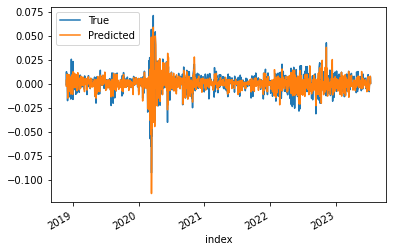

In [20]:
res.plot()

In [21]:
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(figsize=(10, 8))
# xgb.plot_importance(xgbr, importance_type='weight', ax=ax)

In [22]:
np.mean(data['CurrentGap'].abs()>0.0015)

0.6835043409629045

In [23]:
df_compare_reg = df_final.drop(columns=['Target','Target_clf']).merge(res, left_index=True, right_index=True)
df_compare_reg = df_compare_reg.merge(data[['PrevClose','High','Low','Close']], left_index=True, right_index=True)

In [24]:
# How often was the predicted OHLC4 within the current day's range?
df_compare_reg['PredOHLC4'] = df_compare_reg['Predicted'].shift(1)
df_compare_reg['PredOHLC4'] = (1 + df_compare_reg['PredOHLC4']) * df_compare_reg['PrevClose']

In [25]:
df_compare_reg['InRange'] = (df_compare_reg['PredOHLC4'] <= df_compare_reg['High']) & (df_compare_reg['PredOHLC4'] >= df_compare_reg['Low'])

In [26]:
df_compare_reg['InRange'].mean()

0.9106529209621993

In [27]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, PrecisionRecallDisplay

# When the predicted OHLC4 was positive, how often was it a green day?
df_compare_reg['PredDirection'] = df_compare_reg['Predicted'] > 0
# df_compare_reg['PredDirection'] = df_compare_reg['PredDirection'].shift(1)
df_compare_reg['ActualDirection'] = df_compare_reg['Close'] > df_compare_reg['PrevClose']
df_compare_reg['ActualDirection'] = df_compare_reg['ActualDirection'].shift(-1)

In [28]:
df_compare_reg.pivot_table(columns='PredDirection', index='ActualDirection', values='Close', aggfunc='count')

PredDirection,False,True
ActualDirection,,
False,374,162
True,164,463


In [29]:
compare_ohlc4_model = df_compare_reg.dropna(subset=['PredDirection','ActualDirection'])
print(roc_auc_score(compare_ohlc4_model['ActualDirection'].astype(int), compare_ohlc4_model['PredDirection'].astype(int)))
print(precision_score(compare_ohlc4_model['ActualDirection'].astype(int), compare_ohlc4_model['PredDirection'].astype(int)))
print(recall_score(compare_ohlc4_model['ActualDirection'].astype(int), compare_ohlc4_model['PredDirection'].astype(int)))

0.7180990978123736
0.7408
0.7384370015948963


# Classification Model

In [30]:
reg_model_out = res[['Predicted']]
reg_model_out.columns = ['RegModelOut']
df_final_seq = df_final.merge(reg_model_out, left_index=True, right_index=True)
df_final_seq['RegModelOut'] = df_final_seq['RegModelOut'] > 0

In [31]:
df_final_seq

,BigNewsDay,Quarter,Perf5Day,Perf5Day_n1,DaysGreen,DaysRed,CurrentGap,GapLevel,RangePct,RangePct_n1,RangePct_n2,OHLC4_VIX,OHLC4_VIX_n1,OHLC4_VIX_n2,Target,Target_clf,RegModelOut
index,,,,,,,,,,,,,,,,,
2018-11-26,0.0,4,False,False,1,0,-0.003628,1,0.009119,0.006252,0.007891,19.7875,21.5125,21.2200,-0.000885,True,False
2018-11-27,1.0,4,False,False,2,0,0.003460,4,0.009932,0.009119,0.006252,19.2650,19.7875,21.5125,0.012578,True,True
2018-11-28,1.0,4,True,False,3,0,-0.002486,2,0.021729,0.009932,0.009119,18.7300,19.2650,19.7875,-0.002159,False,False
2018-11-29,0.0,4,True,True,0,1,-0.000015,3,0.011254,0.021729,0.009932,19.1275,18.7300,19.2650,0.003686,True,True
2018-11-30,0.0,4,True,True,1,0,0.010988,4,0.010188,0.011254,0.021729,18.7975,19.1275,18.7300,0.010303,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-07,0.0,3,True,True,0,3,-0.001073,3,0.009773,0.008516,0.003924,15.2975,15.5400,14.2900,0.000596,True,False
2023-07-10,0.0,3,False,True,1,0,0.001365,3,0.005143,0.009773,0.008516,15.6000,15.2975,15.5400,0.003900,True,True
2023-07-11,1.0,3,False,False,2,0,0.006404,4,0.007925,0.005143,0.009773,14.9350,15.6000,15.2975,0.007568,True,True


In [32]:
df_final_seq = df_final_seq.drop(columns=['Target'])

In [33]:
df_final_seq['Target_clf'] = df_final_seq['Target_clf'].astype(bool)

In [34]:
res1, xgbc = walk_forward_validation_clf(df_final_seq.dropna(), 'Target_clf', 100, 1)

100%|██████████| 1064/1064 [00:12<00:00, 85.64it/s]


In [35]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, PrecisionRecallDisplay
print(roc_auc_score(res1['True'].astype(int), res1['Predicted'].values))
print(precision_score(res1['True'].astype(int), res1['Predicted'] > 0.5))
print(recall_score(res1['True'].astype(int), res1['Predicted'] > 0.5))
# print(roc_auc_score(res1['True'].astype(int), res1['Predicted'].values))

0.7427741049471432
0.7094017094017094
0.7319223985890653


In [36]:
res1['True'].mean()

0.5328947368421053

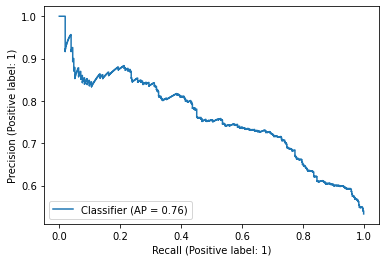

In [37]:
PrecisionRecallDisplay.from_predictions(res1['True'].astype(int), res1['Predicted'].values)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

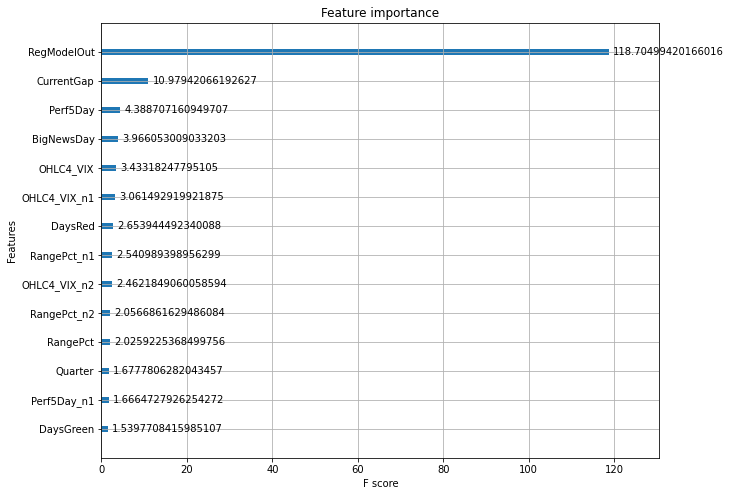

In [38]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(xgbc, importance_type='gain', ax=ax)

In [39]:
df_compare = df_final.drop(columns=['Target','Target_clf']).merge(res1, left_index=True, right_index=True)

# What do these false positives look like?
# false_pos = df_compare.loc[(df_compare['True'] == False) & (df_compare['Predicted'] > 0.5)]

In [40]:
# Label fp, tp, fn, tn
def label_type(actual, pred):
    if actual == True and pred > 0.5:
        return 'TP'
    elif actual == False and pred > 0.5:
        return 'FP'
    elif actual == False and pred <= 0.5:
        return 'TN'
    elif actual == True and pred <= 0.5:
        return 'FN'

df_compare['label_type'] = [label_type(actual, pred) for actual, pred in zip(df_compare['True'],df_compare['Predicted'])]

In [41]:
df_compare.groupby('label_type')['True'].count()

label_type
FN    152
FP    170
TN    327
TP    415
Name: True, dtype: int64

In [42]:
302 / (302 + 109)

0.7347931873479319

In [43]:
266 / (266 + 107)

0.7131367292225201

In [44]:
df_compare_clf = df_final.drop(columns=['Target','Target_clf']).merge(res1, left_index=True, right_index=True)
df_compare_clf = df_compare_clf.merge(data[['PrevClose','High','Low','Close']], left_index=True, right_index=True)

# When the predicted OHLC4 was positive, how often was it a green day?
df_compare_clf['PredDirection'] = df_compare_clf['Predicted'] > 0.5
# df_compare_reg['PredDirection'] = df_compare_reg['PredDirection'].shift(1)
df_compare_clf['ActualDirection'] = df_compare_clf['Close'] > df_compare_clf['PrevClose']
df_compare_clf['ActualDirection'] = df_compare_clf['ActualDirection'].shift(-1)

In [45]:
df_compare_clf

,BigNewsDay,Quarter,Perf5Day,Perf5Day_n1,DaysGreen,DaysRed,CurrentGap,GapLevel,RangePct,RangePct_n1,...,OHLC4_VIX_n1,OHLC4_VIX_n2,True,Predicted,PrevClose,High,Low,Close,PredDirection,ActualDirection
index,,,,,,,,,,,,,,,,,,,,,
2019-04-23,0.0,2,True,True,3,0,0.000109,3,0.009469,0.004525,...,12.8425,12.5075,False,0.348350,2907.969971,2936.310059,2908.530029,2933.679932,False,False
2019-04-24,1.0,2,True,True,0,1,0.000594,3,0.003683,0.009469,...,12.4275,12.8425,False,0.499399,2933.679932,2936.830078,2926.050049,2927.250000,False,False
2019-04-25,1.0,2,True,True,0,2,-0.000123,3,0.006924,0.003683,...,12.7900,12.4275,True,0.195689,2927.250000,2933.100098,2912.840088,2926.169922,False,True
2019-04-26,1.0,2,True,True,1,0,0.000238,3,0.007592,0.006924,...,13.4125,12.7900,True,0.639491,2926.169922,2939.879883,2917.560059,2939.879883,True,True
2019-04-29,0.0,2,True,True,2,0,-0.002001,2,0.003456,0.007592,...,13.0700,13.4125,True,0.653846,2939.879883,2949.520020,2939.350098,2943.030029,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-07,0.0,3,True,True,0,3,-0.001073,3,0.009773,0.008516,...,15.5400,14.2900,True,0.543581,4411.589844,4440.390137,4397.399902,4398.950195,True,True
2023-07-10,0.0,3,False,True,1,0,0.001365,3,0.005143,0.009773,...,15.2975,15.5400,True,0.824980,4398.950195,4412.600098,4389.919922,4409.529785,True,True
2023-07-11,1.0,3,False,False,2,0,0.006404,4,0.007925,0.005143,...,15.6000,15.2975,True,0.963887,4409.529785,4443.640137,4408.459961,4439.259766,True,True


In [46]:
df_compare_clf.pivot_table(columns='PredDirection', index='ActualDirection', values='Close', aggfunc='count')

PredDirection,False,True
ActualDirection,,
False,327,169
True,152,415


In [47]:
276 / (276 + 133)

0.6748166259168704

# Sequential Model

In [48]:
res2, seq2 = walk_forward_validation_seq(df_final.dropna(), 'Target_clf', 'Target', 100, 1)

100%|██████████| 1164/1164 [00:03<00:00, 385.97it/s]
C:\Users\WINSTON-ITX\AppData\Local\Temp\ipykernel_24132\235211327.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_merge['RegrModelOut'] = for_merge['RegrModelOut'] > 0
100%|██████████| 1064/1064 [00:09<00:00, 115.34it/s]


In [49]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, PrecisionRecallDisplay
print(roc_auc_score(res2['True'].astype(int), res2['Predicted'].values))
print(precision_score(res2['True'].astype(int), res2['Predicted'] > 0.5))
print(recall_score(res2['True'].astype(int), res2['Predicted'] > 0.5))
# print(roc_auc_score(res1['True'].astype(int), res1['Predicted'].values))

0.7376853714881884
0.6862416107382551
0.7213403880070547


In [50]:
res2.groupby(res2['Predicted'] <= 0.42).agg({'True':[np.mean,len,np.sum]})

True          
               mean  len  sum
Predicted                    
False      0.662757  682  452
True       0.301047  382  115

In [51]:
res2.groupby(pd.qcut(res2['Predicted'],5)).agg({'True':[np.mean,len,np.sum]})

True          
                     mean  len  sum
Predicted                          
(0.0481, 0.274]  0.244131  213   52
(0.274, 0.47]    0.399061  213   85
(0.47, 0.661]    0.523585  212  111
(0.661, 0.838]   0.685446  213  146
(0.838, 0.954]   0.812207  213  173

In [52]:
len(res2)

1064

In [53]:
res2.groupby(res2['Predicted'] > .93).agg({'True':[np.mean,len]})

True      
               mean   len
Predicted                
False      0.522593  1018
True       0.760870    46

In [54]:
res2['Predicted']

index
2019-04-23    0.615764
2019-04-24    0.243159
2019-04-25    0.322760
2019-04-26    0.217133
2019-04-29    0.535138
                ...   
2023-07-07    0.364264
2023-07-10    0.667768
2023-07-11    0.810105
2023-07-12    0.912171
2023-07-13    0.471872
Name: Predicted, Length: 1064, dtype: float32

In [55]:
df_final_seq

,BigNewsDay,Quarter,Perf5Day,Perf5Day_n1,DaysGreen,DaysRed,CurrentGap,GapLevel,RangePct,RangePct_n1,RangePct_n2,OHLC4_VIX,OHLC4_VIX_n1,OHLC4_VIX_n2,Target_clf,RegModelOut
index,,,,,,,,,,,,,,,,
2018-11-26,0.0,4,False,False,1,0,-0.003628,1,0.009119,0.006252,0.007891,19.7875,21.5125,21.2200,True,False
2018-11-27,1.0,4,False,False,2,0,0.003460,4,0.009932,0.009119,0.006252,19.2650,19.7875,21.5125,True,True
2018-11-28,1.0,4,True,False,3,0,-0.002486,2,0.021729,0.009932,0.009119,18.7300,19.2650,19.7875,False,False
2018-11-29,0.0,4,True,True,0,1,-0.000015,3,0.011254,0.021729,0.009932,19.1275,18.7300,19.2650,True,True
2018-11-30,0.0,4,True,True,1,0,0.010988,4,0.010188,0.011254,0.021729,18.7975,19.1275,18.7300,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-07,0.0,3,True,True,0,3,-0.001073,3,0.009773,0.008516,0.003924,15.2975,15.5400,14.2900,True,False
2023-07-10,0.0,3,False,True,1,0,0.001365,3,0.005143,0.009773,0.008516,15.6000,15.2975,15.5400,True,True
2023-07-11,1.0,3,False,False,2,0,0.006404,4,0.007925,0.005143,0.009773,14.9350,15.6000,15.2975,True,True


In [56]:
res1['True'].mean()

0.5328947368421053

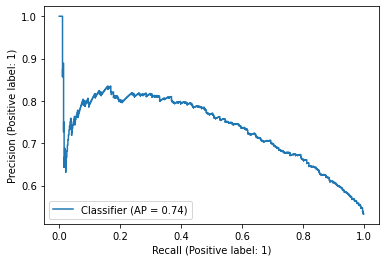

In [57]:
PrecisionRecallDisplay.from_predictions(res2['True'].astype(int), res2['Predicted'].values)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

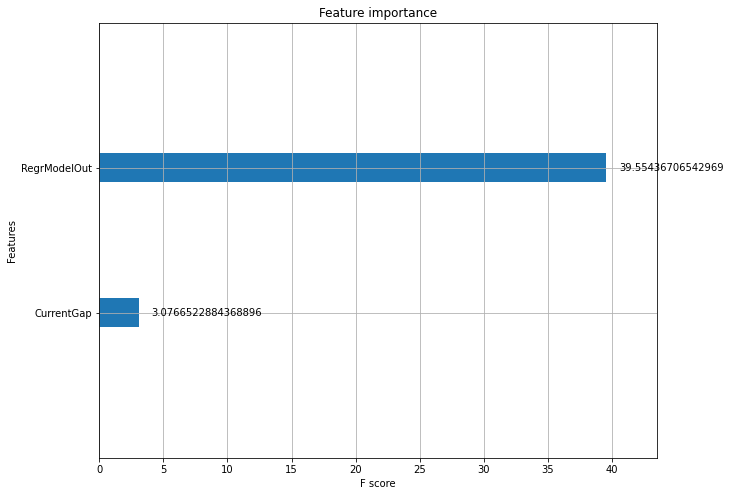

In [58]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(seq2, importance_type='gain', ax=ax)

In [59]:
df_compare = df_final.drop(columns=['Target','Target_clf']).merge(res2, left_index=True, right_index=True)

# What do these false positives look like?
# false_pos = df_compare.loc[(df_compare['True'] == False) & (df_compare['Predicted'] > 0.5)]

In [60]:
# Label fp, tp, fn, tn
def label_type(actual, pred):
    if actual == True and pred > 0.5:
        return 'TP'
    elif actual == False and pred > 0.5:
        return 'FP'
    elif actual == False and pred <= 0.5:
        return 'TN'
    elif actual == True and pred <= 0.5:
        return 'FN'

df_compare['label_type'] = [label_type(actual, pred) for actual, pred in zip(df_compare['True'],df_compare['Predicted'])]

In [61]:
df_compare.groupby('label_type')['True'].count()

label_type
FN    158
FP    187
TN    310
TP    409
Name: True, dtype: int64

In [62]:
302 / (302 + 109)

0.7347931873479319

In [63]:
266 / (266 + 107)

0.7131367292225201

In [64]:
df_compare_clf = df_final.drop(columns=['Target','Target_clf']).merge(res2, left_index=True, right_index=True)
df_compare_clf = df_compare_clf.merge(data[['PrevClose','High','Low','Close']], left_index=True, right_index=True)

# When the predicted OHLC4 was positive, how often was it a green day?
df_compare_clf['PredDirection'] = df_compare_clf['Predicted'] > 0.5
# df_compare_reg['PredDirection'] = df_compare_reg['PredDirection'].shift(1)
df_compare_clf['ActualDirection'] = df_compare_clf['Close'] > df_compare_clf['PrevClose']
df_compare_clf['ActualDirection'] = df_compare_clf['ActualDirection'].shift(-1)

In [65]:
df_compare_clf

,BigNewsDay,Quarter,Perf5Day,Perf5Day_n1,DaysGreen,DaysRed,CurrentGap,GapLevel,RangePct,RangePct_n1,...,OHLC4_VIX_n1,OHLC4_VIX_n2,True,Predicted,PrevClose,High,Low,Close,PredDirection,ActualDirection
index,,,,,,,,,,,,,,,,,,,,,
2019-04-23,0.0,2,True,True,3,0,0.000109,3,0.009469,0.004525,...,12.8425,12.5075,False,0.615764,2907.969971,2936.310059,2908.530029,2933.679932,True,False
2019-04-24,1.0,2,True,True,0,1,0.000594,3,0.003683,0.009469,...,12.4275,12.8425,False,0.243159,2933.679932,2936.830078,2926.050049,2927.250000,False,False
2019-04-25,1.0,2,True,True,0,2,-0.000123,3,0.006924,0.003683,...,12.7900,12.4275,True,0.322760,2927.250000,2933.100098,2912.840088,2926.169922,False,True
2019-04-26,1.0,2,True,True,1,0,0.000238,3,0.007592,0.006924,...,13.4125,12.7900,True,0.217133,2926.169922,2939.879883,2917.560059,2939.879883,False,True
2019-04-29,0.0,2,True,True,2,0,-0.002001,2,0.003456,0.007592,...,13.0700,13.4125,True,0.535138,2939.879883,2949.520020,2939.350098,2943.030029,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-07,0.0,3,True,True,0,3,-0.001073,3,0.009773,0.008516,...,15.5400,14.2900,True,0.364264,4411.589844,4440.390137,4397.399902,4398.950195,False,True
2023-07-10,0.0,3,False,True,1,0,0.001365,3,0.005143,0.009773,...,15.2975,15.5400,True,0.667768,4398.950195,4412.600098,4389.919922,4409.529785,True,True
2023-07-11,1.0,3,False,False,2,0,0.006404,4,0.007925,0.005143,...,15.6000,15.2975,True,0.810105,4409.529785,4443.640137,4408.459961,4439.259766,True,True


In [66]:
df_compare_clf.pivot_table(columns='PredDirection', index='ActualDirection', values='Close', aggfunc='count')

PredDirection,False,True
ActualDirection,,
False,309,187
True,158,409


# New Prediction

In [67]:
# Get last row
new_pred = data.loc[final_row, ['BigNewsDay',
    'Quarter',
    'Perf5Day',
    'Perf5Day_n1',    
    'DaysGreen',    
    'DaysRed',    
    # 'OHLC4_Trend',    
    # 'OHLC4_Trend_n1',    
    # 'OHLC4_Trend_n2',    
    # 'VIX5Day',
    # 'VIX5Day_n1',
    'CurrentGap',
    'GapLevel',
    'RangePct',
    'RangePct_n1',
    'RangePct_n2',
    'OHLC4_VIX',
    'OHLC4_VIX_n1',
    'OHLC4_VIX_n2']]

new_pred = pd.DataFrame(new_pred).T

new_pred['BigNewsDay'] = new_pred['BigNewsDay'].astype(float)
new_pred['Quarter'] = new_pred['Quarter'].astype(int)
new_pred['Perf5Day'] = new_pred['Perf5Day'].astype(bool)
new_pred['Perf5Day_n1'] = new_pred['Perf5Day_n1'].astype(bool)
new_pred['DaysGreen'] = new_pred['DaysGreen'].astype(float)
new_pred['DaysRed'] = new_pred['DaysRed'].astype(float)
# new_pred['OHLC4_Trend'] = new_pred['OHLC4_Trend'].astype(float)
# new_pred['OHLC4_Trend_n1'] = new_pred['OHLC4_Trend_n1'].astype(float)
# new_pred['OHLC4_Trend_n2'] = new_pred['OHLC4_Trend_n2'].astype(float)
# new_pred['VIX5Day'] = new_pred['VIX5Day'].astype(bool)
# new_pred['VIX5Day_n1'] = new_pred['VIX5Day_n1'].astype(bool)
new_pred['CurrentGap'] = new_pred['CurrentGap'].astype(float)
new_pred['GapLevel'] = new_pred['GapLevel'].astype(int)
new_pred['RangePct'] = new_pred['RangePct'].astype(float)
new_pred['RangePct_n1'] = new_pred['RangePct_n1'].astype(float)
new_pred['RangePct_n2'] = new_pred['RangePct_n2'].astype(float)
new_pred['OHLC4_VIX'] = new_pred['OHLC4_VIX'].astype(float)
new_pred['OHLC4_VIX_n1'] = new_pred['OHLC4_VIX_n1'].astype(float)
new_pred['OHLC4_VIX_n2'] = new_pred['OHLC4_VIX_n2'].astype(float)

# The only variable you can play with as the other ones are historical
# new_pred.loc[:,'CurrentGap'] = -0.01 / 100
# new_pred.loc[:,'BigNewsDay'] = 0

In [68]:
new_pred

,BigNewsDay,Quarter,Perf5Day,Perf5Day_n1,DaysGreen,DaysRed,CurrentGap,GapLevel,RangePct,RangePct_n1,RangePct_n2,OHLC4_VIX,OHLC4_VIX_n1,OHLC4_VIX_n2
2023-07-13,0.0,3,True,True,4.0,0.0,0.001013,3,0.006213,0.005615,0.007925,13.445,14.1725,14.935


In [69]:
seq_predict_proba(new_pred, xgbr, seq2)

array([0.471872], dtype=float32)

In [70]:
res2.groupby(res2['Predicted'] >= 0.59).agg({'True':[np.mean,len,np.sum]})

True          
               mean  len  sum
Predicted                    
False      0.362976  551  200
True       0.715400  513  367

In [71]:
res2.groupby(pd.qcut(res2['Predicted'],5)).agg({'True':[np.mean,len,np.sum]})

True          
                     mean  len  sum
Predicted                          
(0.0481, 0.274]  0.244131  213   52
(0.274, 0.47]    0.399061  213   85
(0.47, 0.661]    0.523585  212  111
(0.661, 0.838]   0.685446  213  146
(0.838, 0.954]   0.812207  213  173

In [72]:
res2

,True,Predicted
index,,
2019-04-23,False,0.615764
2019-04-24,False,0.243159
2019-04-25,True,0.322760
2019-04-26,True,0.217133
2019-04-29,True,0.535138
...,...,...
2023-07-07,True,0.364264
2023-07-10,True,0.667768
2023-07-11,True,0.810105


## Pre Market Prediction

In [73]:
# Get actual last row
exp_pred = data[['BigNewsDay',
    'Quarter',
    'Perf5Day',
    'Perf5Day_n1',    
    'DaysGreen',    
    'DaysRed',    
    # 'OHLC4_Trend',    
    # 'OHLC4_Trend_n1',    
    # 'OHLC4_Trend_n2',    
    # 'VIX5Day',
    # 'VIX5Day_n1',
    'CurrentGap',
    'GapLevel',
    'RangePct',
    'RangePct_n1',
    'RangePct_n2',
    'OHLC4_VIX',
    'OHLC4_VIX_n1',
    'OHLC4_VIX_n2']].iloc[-1]

exp_pred = pd.DataFrame(exp_pred).T

exp_pred['BigNewsDay'] = exp_pred['BigNewsDay'].astype(float)
exp_pred['Quarter'] = exp_pred['Quarter'].astype(int)
exp_pred['Perf5Day'] = exp_pred['Perf5Day'].astype(bool)
exp_pred['Perf5Day_n1'] = exp_pred['Perf5Day_n1'].astype(bool)
exp_pred['DaysGreen'] = exp_pred['DaysGreen'].astype(float)
exp_pred['DaysRed'] = exp_pred['DaysRed'].astype(float)
# exp_pred['OHLC4_Trend'] = exp_pred['OHLC4_Trend'].astype(float)
# exp_pred['OHLC4_Trend_n1'] = exp_pred['OHLC4_Trend_n1'].astype(float)
# exp_pred['OHLC4_Trend_n2'] = exp_pred['OHLC4_Trend_n2'].astype(float)
# exp_pred['VIX5Day'] = exp_pred['VIX5Day'].astype(bool)
# exp_pred['VIX5Day_n1'] = exp_pred['VIX5Day_n1'].astype(bool)
exp_pred['CurrentGap'] = exp_pred['CurrentGap'].astype(float)
exp_pred['GapLevel'] = exp_pred['GapLevel'].astype(int)
exp_pred['RangePct'] = exp_pred['RangePct'].astype(float)
exp_pred['RangePct_n1'] = exp_pred['RangePct_n1'].astype(float)
exp_pred['RangePct_n2'] = exp_pred['RangePct_n2'].astype(float)
exp_pred['OHLC4_VIX'] = exp_pred['OHLC4_VIX'].astype(float)
exp_pred['OHLC4_VIX_n1'] = exp_pred['OHLC4_VIX_n1'].astype(float)
exp_pred['OHLC4_VIX_n2'] = exp_pred['OHLC4_VIX_n2'].astype(float)

# The only variable you can play with as the other ones are historical
exp_pred.loc[:,'CurrentGap'] = 10 / 4472
# new_pred.loc[:,'BigNewsDay'] = 0

In [74]:
seq_predict_proba(exp_pred, xgbr, seq2)

array([0.6691697], dtype=float32)